In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger # есть проблема с просмотром логгов, запишу допом в csv
import torchmetrics

In [132]:
pl.seed_everything(1, workers=True)

Seed set to 1


1

Архитектура:
2 сверточных слоя
-> pooling
--> 2 полносвязных слоя

CNN — стандартная история для изображений

Ну и сама модель маленькая а значит быстро обучается и не переобучается

Оптимизатор: Adam, просто для стандарта

Scheduler: ReduceLROnPlateau, удобный тк сам уменьшает lrate, если val loss перестал улучшаться

In [135]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # тензоризация и нормализация трансформером
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        # скачивание трен и тест датасета по train=True/False
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # full train
        full_train = FashionMNIST(
            self.data_dir,
            train=True,
            transform=self.transform
        )

        # train на train/val
        self.train_ds, self.val_ds = random_split(
            full_train, [55000, 5000]
        )

        # test
        self.test_ds = FashionMNIST(
            self.data_dir,
            train=False,
            transform=self.transform
        )

    # dataloaders
    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size
        )

In [137]:
class FashionMNISTModel(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.save_hyperparameters()

        # архитектура
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # сверточн слои, двухмерный (входной канал, выходеой, 3х3 размер, 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # + padding прибавляет по 1 пикселю по краям)
        self.pool = nn.MaxPool2d(2) # пуллинг
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # полносвязный слой, с 28 на 14, с 14 - на 7 после пуллинга
        self.fc2 = nn.Linear(128, 10) # выходной полносвязный слой, 10 - кол-во классов многоклассовой классификации из набора (от футболки до ботинков)
        self.loss_fn = nn.CrossEntropyLoss() # стандартная для многоклассовой классификации функция потерь
        
        # по метрикам F1 and AucRoc:
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=10, average="macro")
        self.val_auc = torchmetrics.AUROC(task="multiclass", num_classes=10)
        self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=10, average="macro")
        self.test_auc = torchmetrics.AUROC(task="multiclass", num_classes=10)
        
    # стандартные этапы
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        probs = torch.softmax(logits, dim=1)
        self.val_f1(probs, y)
        self.val_auc(probs, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)
        self.log("val_auc", self.val_auc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        probs = torch.softmax(logits, dim=1)
        self.test_f1(probs, y)
        self.test_auc(probs, y)
        self.log("test_loss", loss)
        self.log("test_f1", self.test_f1)
        self.log("test_auc", self.test_auc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            patience=2,
            factor=0.5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

In [139]:
datamodule = FashionMNISTDataModule(batch_size=64)
model = FashionMNISTModel()

In [141]:
tb_logger = TensorBoardLogger("logs", name="fashion_mnist")
csv_logger = CSVLogger("logs", name="fashion_mnist_csv")

In [143]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
)

trainer = Trainer(
    max_epochs=15, # на рандом. тк есть ранняя остановка, в целом для простой задачки 15 и менее эпох хватит
    callbacks=[early_stopping],
    logger=[tb_logger, csv_logger],  # приходится писать два логгера из-за проблемы с окружением
    deterministic=True,
    accelerator="auto",
    devices=1 # на gpu
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [145]:
trainer.fit(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1    │ Conv2d            │    320 │ train │     0 │
│ 1 │ conv2    │ Conv2d            │ 18.5 K │ train │     0 │
│ 2 │ pool     │ MaxPool2d         │      0 │ train │     0 │
│ 3 │ fc1      │ Linear            │  401 K │ train │     0 │
│ 4 │ fc2      │ Linear            │  1.3 K │ train │     0 │
│ 5 │ loss_fn  │ CrossEntropyLoss  │      0 │ train │     0 │
│ 6 │ val_f1   │ MulticlassF1Score │      0 │ train │     0 │
│ 7 │ val_auc  │ MulticlassAUROC   │      0 │ train │     0 │
│ 8 │ test_f1  │ MulticlassF1Score │      0 │ train │     0 │
│ 9 │ test_auc │ MulticlassAUROC   │      0 │ train │     0 │
└───┴──────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 421 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 421 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [147]:
trainer.test(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.9952598810195923     │
│          test_f1          │    0.9232580661773682     │
│         test_loss         │    0.2520861327648163     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2520861327648163,
  'test_f1': 0.9232580661773682,
  'test_auc': 0.9952598810195923}]

In [149]:
%load_ext tensorboard
%tensorboard --logdir logs/fashion_mnist/version_1/checkpoints

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\user\anaconda3\Scripts\tensorboard.exe\__main__.py", line 2, in <module>
  File "C:\Users\user\anaconda3\Lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\user\anaconda3\Lib\site-packages\tensorboard\default.py", line 30, in <module>
    import pkg_resources
  File "C:\Users\user\anaconda3\Lib\site-packages\pkg_resources\__init__.py", line 90, in <module>
    from jaraco.text import drop_comment, join_continuation, yield_lines
  File "C:\Users\user\anaconda3\Lib\site-packages\setuptools\_vendor\jaraco\text\__init__.py", line 12, in <module>
    from jaraco.context import ExceptionTrap
  File "C:\Users\user\anaconda3\Lib\site-packages\setuptools\_vendor\jaraco\context.py", line 17, in <module>
    

In [100]:
# Тк выдается ошибка, которую не получилось решить апдейтами и сравнением библиотек, буду использовать аналог для визуализации

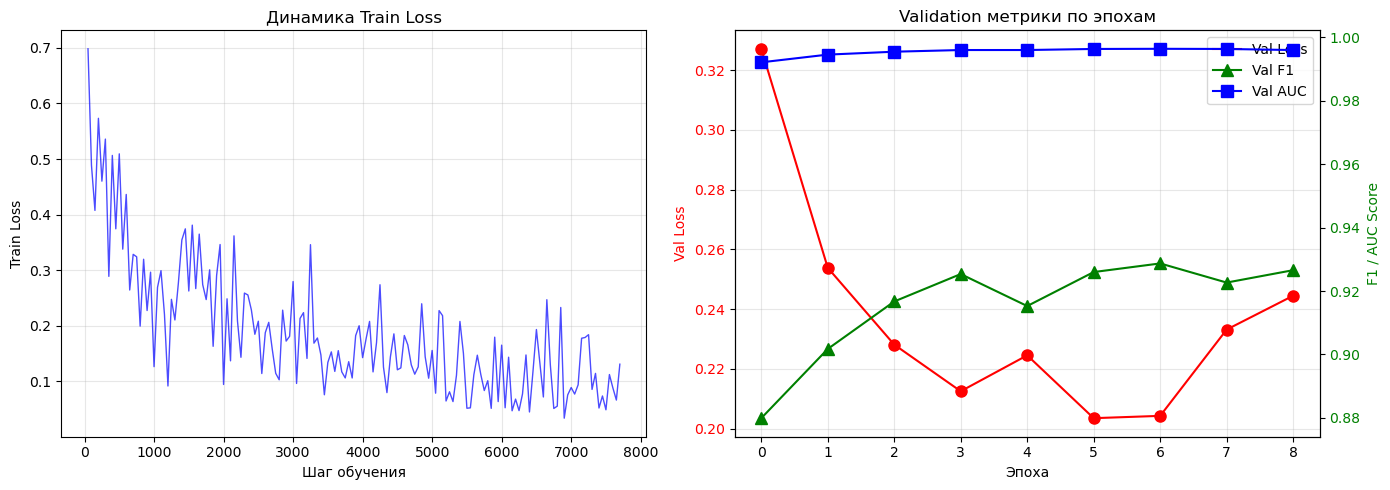


Сводка по эпохам:
 epoch  val_loss   val_f1  val_auc
   0.0  0.327131 0.879936 0.992051
   1.0  0.253845 0.901741 0.994483
   2.0  0.228138 0.916706 0.995397
   3.0  0.212538 0.925342 0.995925
   4.0  0.224561 0.915263 0.995927
   5.0  0.203530 0.925973 0.996262
   6.0  0.204304 0.928692 0.996313
   7.0  0.233173 0.922661 0.996263
   8.0  0.244499 0.926563 0.995918


In [157]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("logs/fashion_mnist_csv/version_0/metrics.csv")

# Фильтруем данные
train_data = df[['step', 'train_loss']].dropna()
val_data = df[['epoch', 'val_loss', 'val_f1', 'val_auc']].dropna()

# Создаем график
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Левый график: Train Loss по шагам
ax1.plot(train_data['step'], train_data['train_loss'], 'b-', alpha=0.7, linewidth=1)
ax1.set_xlabel('Шаг обучения')
ax1.set_ylabel('Train Loss')
ax1.set_title('Динамика Train Loss')
ax1.grid(True, alpha=0.3)

# Правый график: Validation метрики по эпохам
if not val_data.empty:
    epochs = val_data['epoch'].unique()
    
    # Для каждой эпохи берем последнюю запись
    val_metrics = []
    for epoch in epochs:
        epoch_data = val_data[val_data['epoch'] == epoch].iloc[-1]
        val_metrics.append(epoch_data)
    
    val_df = pd.DataFrame(val_metrics)
    
    ax2.plot(val_df['epoch'], val_df['val_loss'], 'ro-', label='Val Loss', markersize=8)
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Val Loss', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_title('Validation метрики по эпохам')
    ax2.grid(True, alpha=0.3)
    
    # Вторная ось Y для F1 и AUC
    ax2_f1 = ax2.twinx()
    ax2_f1.plot(val_df['epoch'], val_df['val_f1'], 'g^-', label='Val F1', markersize=8)
    ax2_f1.plot(val_df['epoch'], val_df['val_auc'], 'bs-', label='Val AUC', markersize=8)
    ax2_f1.set_ylabel('F1 / AUC Score', color='green')
    ax2_f1.tick_params(axis='y', labelcolor='green')
    
    # Объединяем легенды
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_f1.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Выводим таблицу с результатами
print("\nСводка по эпохам:")
print(val_df[['epoch', 'val_loss', 'val_f1', 'val_auc']].to_string(index=False))

по эпохам F1-score вырос с 0.88 до 0.93 - качество классификации улучшалось до 7 эпохи включительно
AUC стабильно высокий (>0.99) - модель хорошо разделяет классы
Val loss снизился с 0.33 до 0.20 - модель лучше обучается
Проблема: на 8-й эпохе val loss увеличился (0.204 - 0.233), хотя train loss скорее всего продолжал снижаться
надо ограничиться 7 эпохами, переобучить модель и выдать лучший результат

In [164]:
model = FashionMNISTModel(lr=0.001)

# Просто уменьшаем max_epochs
trainer = Trainer(
    max_epochs=7,  # с 15 на 7
    callbacks=[],
    logger=csv_logger,
    deterministic=True,
    accelerator="auto",
    devices=1
)

trainer.fit(model, datamodule)

trainer.test(model, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory logs\fashion_mnist_csv\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1    │ Conv2d            │    320 │ train │     0 │
│ 1 │ conv2    │ Conv2d            │ 18.5 K │ train │     0 │
│ 2 │ pool     │ MaxPool2d         │      0 │ train │     0 │
│ 3 │ fc1      │ Linear            │  401 K │ train │     0 │
│ 4 │ fc2      │ Linear            │  1.3 K │ train │     0 │
│ 5 │ loss_fn  │ CrossEntropyLoss  │      0 │ train │     0 │
│ 6 │ val_f1   │ MulticlassF1Score │      0 │ train │     0 │
│ 7 │ val_auc  │ MulticlassAUROC   │      0 │ train │     0 │
│ 8 │ test_f1  │ MulticlassF1Score │      0 │ train │     0 │
│ 9 │ test_auc │ MulticlassAUROC   │      0 │ train │     0 │
└───┴──────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 421 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 421 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

C:\Users\user\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)

`Trainer.fit` stopped: `max_epochs=7` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

C:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.9949299097061157     │
│          test_f1          │     0.915074348449707     │
│         test_loss         │    0.24833156168460846    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.24833156168460846,
  'test_f1': 0.915074348449707,
  'test_auc': 0.9949299097061157}]

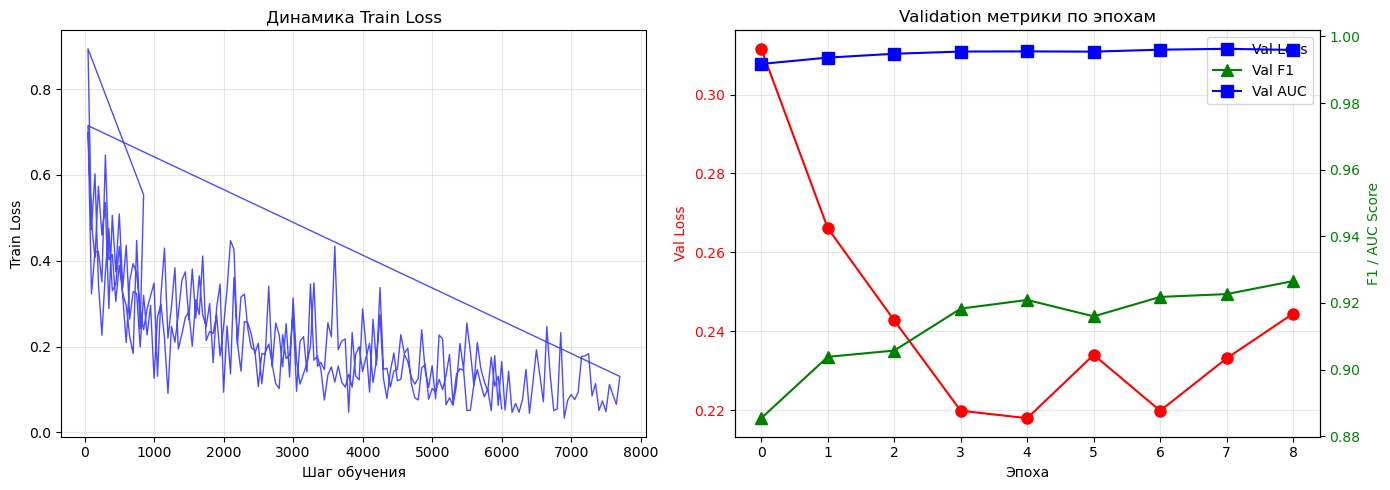


Сводка по эпохам:
 epoch  val_loss   val_f1  val_auc
   0.0  0.311583 0.885429 0.991719
   1.0  0.266146 0.903833 0.993624
   2.0  0.242783 0.905722 0.994772
   3.0  0.219892 0.918296 0.995440
   4.0  0.218013 0.920901 0.995485
   5.0  0.234063 0.915980 0.995412
   6.0  0.219894 0.921811 0.995998
   7.0  0.233173 0.922661 0.996263
   8.0  0.244499 0.926563 0.995918


In [166]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("logs/fashion_mnist_csv/version_0/metrics.csv")

# Фильтруем данные
train_data = df[['step', 'train_loss']].dropna()
val_data = df[['epoch', 'val_loss', 'val_f1', 'val_auc']].dropna()

# Создаем график
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Левый график: Train Loss по шагам
ax1.plot(train_data['step'], train_data['train_loss'], 'b-', alpha=0.7, linewidth=1)
ax1.set_xlabel('Шаг обучения')
ax1.set_ylabel('Train Loss')
ax1.set_title('Динамика Train Loss')
ax1.grid(True, alpha=0.3)

# Правый график: Validation метрики по эпохам
if not val_data.empty:
    epochs = val_data['epoch'].unique()
    
    # Для каждой эпохи берем последнюю запись
    val_metrics = []
    for epoch in epochs:
        epoch_data = val_data[val_data['epoch'] == epoch].iloc[-1]
        val_metrics.append(epoch_data)
    
    val_df = pd.DataFrame(val_metrics)
    
    ax2.plot(val_df['epoch'], val_df['val_loss'], 'ro-', label='Val Loss', markersize=8)
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Val Loss', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_title('Validation метрики по эпохам')
    ax2.grid(True, alpha=0.3)
    
    # Вторная ось Y для F1 и AUC
    ax2_f1 = ax2.twinx()
    ax2_f1.plot(val_df['epoch'], val_df['val_f1'], 'g^-', label='Val F1', markersize=8)
    ax2_f1.plot(val_df['epoch'], val_df['val_auc'], 'bs-', label='Val AUC', markersize=8)
    ax2_f1.set_ylabel('F1 / AUC Score', color='green')
    ax2_f1.tick_params(axis='y', labelcolor='green')
    
    # Объединяем легенды
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_f1.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Выводим таблицу с результатами
print("\nСводка по эпохам:")
print(val_df[['epoch', 'val_loss', 'val_f1', 'val_auc']].to_string(index=False))